In [10]:
import pandas as pd 
import os
import seaborn as sns
raw_data = pd.read_csv('/Users/ethanmeersman/bitcoin.csv')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

## Introduction 

    The dataset's I chose were a Historical Bitcoin Dataset from Kaggle.com, and I went through some of the code people made public to shape my analysis.  I also use an ETH dataset from Kraken as well as a XBT (bitcoin price) dataset from the kraken exchange.  Above are the first libraries, and below I load more for the second dataset I used. I loaded these libraries and wrote some beginning code to smooth the data becuase there were a lot of NA's making it harder for data analysis.  Below is how I cleaned the data using methods we discussed in class like dropna(), resetting the index, changing the time stamp to actul data with the datetime built in function and then dropping the one 2011 record.  Below that is a correlation matrix of all the varibles in the study which draw some interesting results especially between Open and Close prices.  Lastly, in the code below I also show a plot of the Bitcoin High and Close fluctuation plot.  This plot did not come out as cleanly as I wanted it to but it shows that there is a fluctuation with how thick the line is there a a decent spread in what it could be.

In [11]:
## Drop's the N/A's to clean the data
newdata = raw_data.dropna()
## Resets index so the data columns reset after dropping the N/A's
newdata.reset_index(inplace=True, drop=True)
## Changes Timestamp variable to read it in normal time and not UNIX timestamps.
newdata['Timestamp'] = pd.to_datetime(newdata['Timestamp'], unit='s')
## Top 5 records of cleaned data
newdata.head(5)
## Delete 2011 records so it is from 2012 on
newdata.drop([0,1,2,3], inplace=True)
newdata.reset_index(inplace=True, drop=True)
newdata.head()

## Correlation matrix between all variables after dropping NA's
newdata.corr()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Open,1.000000,0.999999,0.999999,0.999999,-0.051860,0.344074,0.999999
High,0.999999,1.000000,0.999998,0.999999,-0.051717,0.344498,0.999999
Low,0.999999,0.999998,1.000000,0.999999,-0.052039,0.343541,1.000000
Close,0.999999,0.999999,0.999999,1.000000,-0.051877,0.344035,1.000000
Volume_(BTC),-0.051860,-0.051717,-0.052039,-0.051877,1.000000,0.352038,-0.051887
Volume_(Currency),0.344074,0.344498,0.343541,0.344035,0.352038,1.000000,0.344010
Weighted_Price,0.999999,0.999999,1.000000,1.000000,-0.051887,0.344010,1.000000


# Plotting 



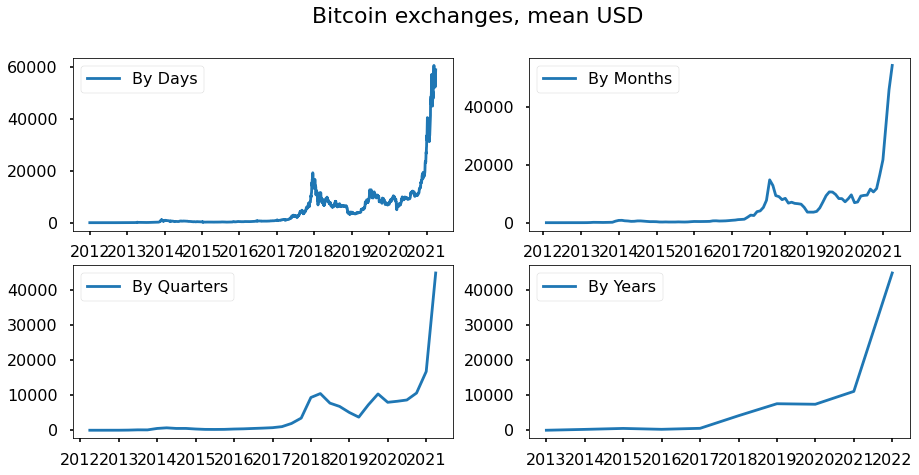

In [13]:
# Unix-time to 
newdata.Timestamp = pd.to_datetime(newdata.Timestamp, unit='s')

# Resampling to daily frequency
newdata.index = newdata.Timestamp
newdata_daily = newdata.resample('D').mean()

# Resampling to monthly frequency
newdata_month = newdata.resample('M').mean()

# Resampling to annual frequency
newdata_year = newdata.resample('A-DEC').mean()

# Resampling to quarterly frequency
newdata_Q = newdata.resample('Q-DEC').mean()

fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, average USD', fontsize=22)

plt.subplot(221)
plt.plot(newdata_daily.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(newdata_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(newdata_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(newdata_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.998820


<Figure size 1080x504 with 0 Axes>

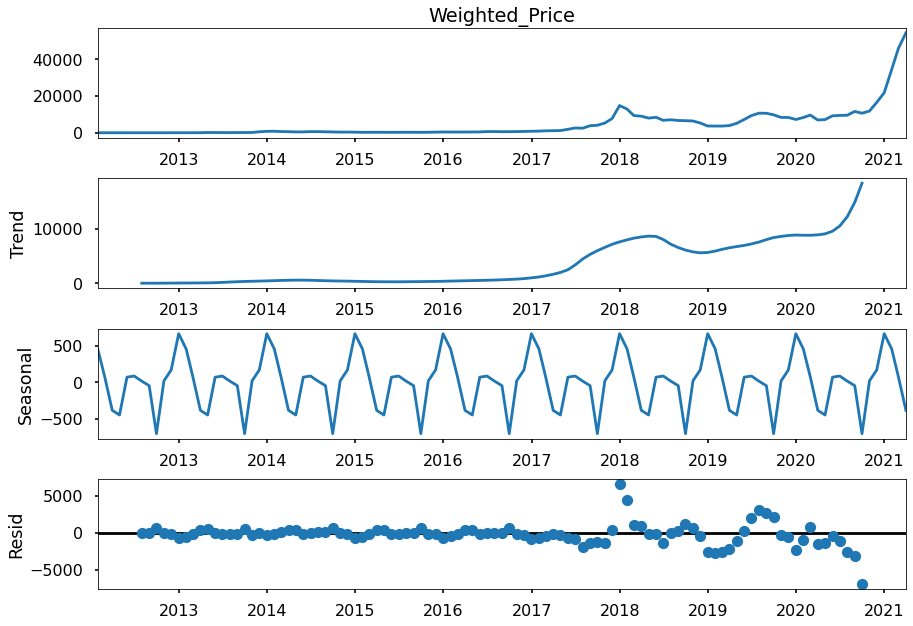

In [27]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(newdata_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(newdata_month.Weighted_Price)[1])
plt.show()

In [17]:
# Seasonal differentiation
newdata_month['prices_box_diff'] = newdata_month.Weighted_Price_box - newdata_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(newdata_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.520925


Dickey–Fuller test: p=0.000048


<Figure size 1080x504 with 0 Axes>

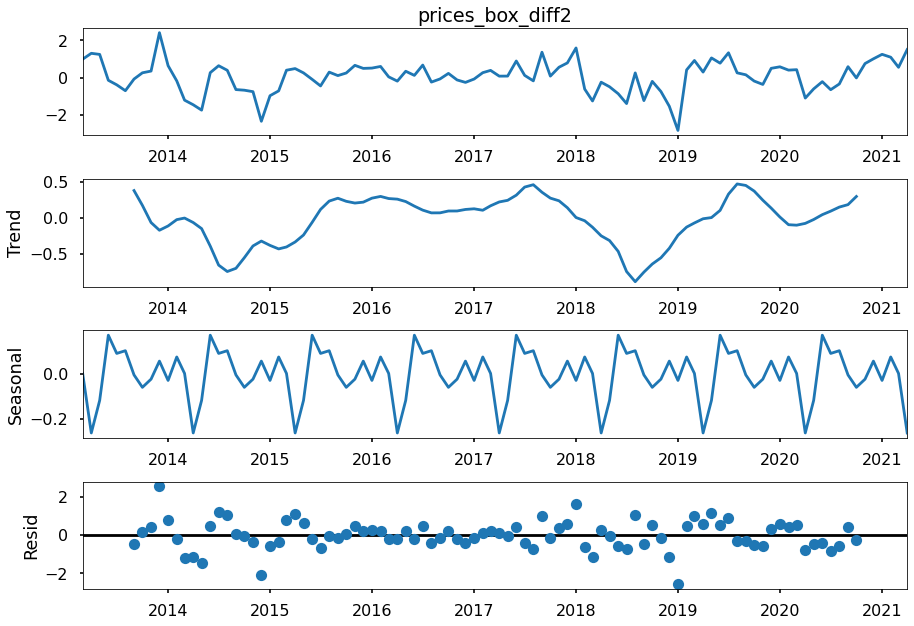

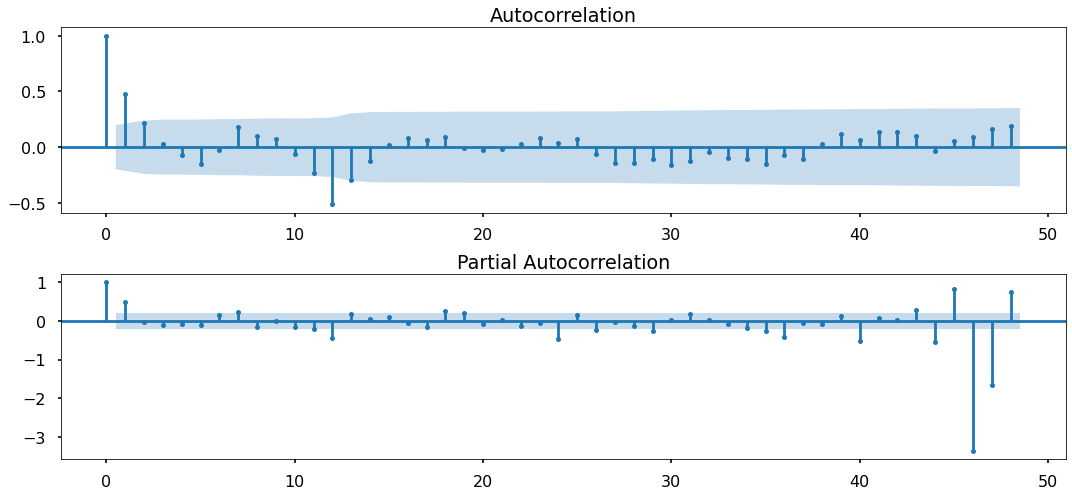

In [22]:
# Regular differentiation
newdata_month['prices_box_diff2'] = newdata_month.prices_box_diff - newdata_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(newdata_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(newdata_month.prices_box_diff2[13:])[1])

# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(newdata_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(newdata_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [25]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(newdata_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
    result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  171.461888
21  (1, 0, 1, 1)  172.655448
25  (1, 1, 0, 1)  173.389539
37  (2, 0, 0, 1)  173.398218
7   (0, 1, 0, 1)  173.457706
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  111
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -82.731
Date:                              Tue, 27 Jul 2021   AIC                            171.462
Time:                                      16:20:19   BIC                            179.217
Sample:                                  01-31-2012   HQIC                           174.599
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


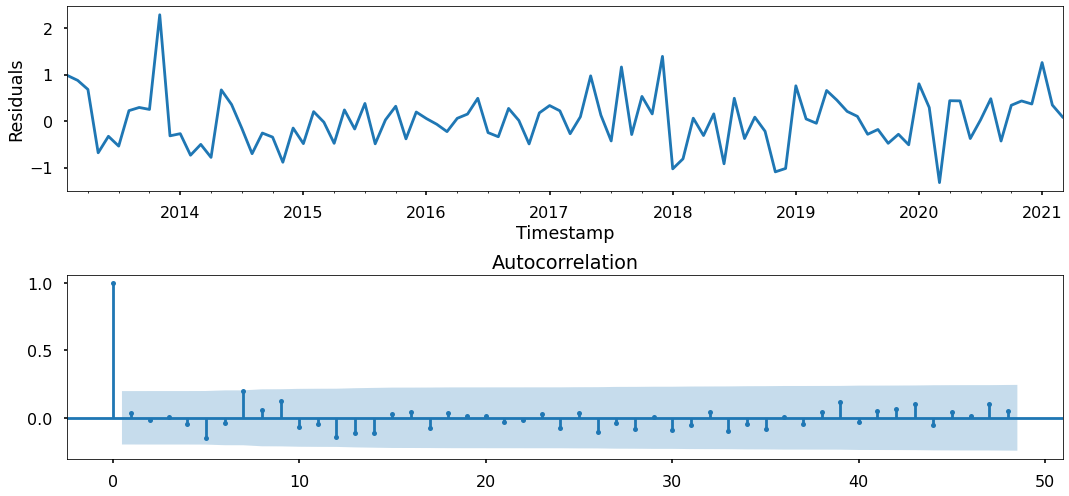

In [28]:
# STL-decomposition and looking at residuals
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

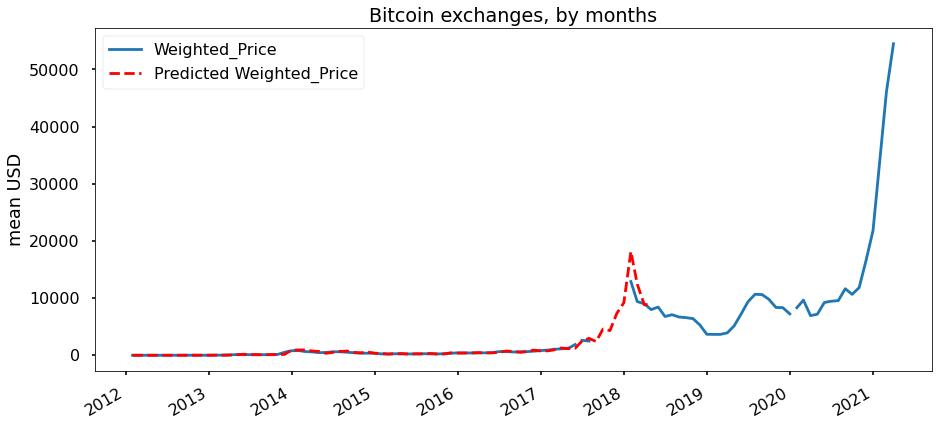

In [36]:
## Prediction 
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    
newdata_month2 = newdata_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2020, 1, 28), datetime(2021, 5, 30)]
future = pd.DataFrame(index=date_list, columns= newdata_month.columns)
newdata_month2 = pd.concat([newdata_month2, future])
newdata_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
newdata_month2.Weighted_Price.plot()
newdata_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()